<a href="https://colab.research.google.com/github/rsnbgt/human_emotion_detection/blob/main/human_emotion_detection_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization,RandomFlip,RandomRotation,RandomContrast,Resizing,Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

Data Loading

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
 89% 276M/309M [00:00<00:00, 398MB/s]
100% 309M/309M [00:00<00:00, 448MB/s]


In [ ]:
!mkdir /content/dataset
!unzip -q human-emotions-datasethes.zip -d "/content/dataset/"

In [ ]:
train_dir="/content/dataset/Emotions Dataset/Emotions Dataset/train"
validation_dir="/content/dataset/Emotions Dataset/Emotions Dataset/test"

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 128,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


EDA

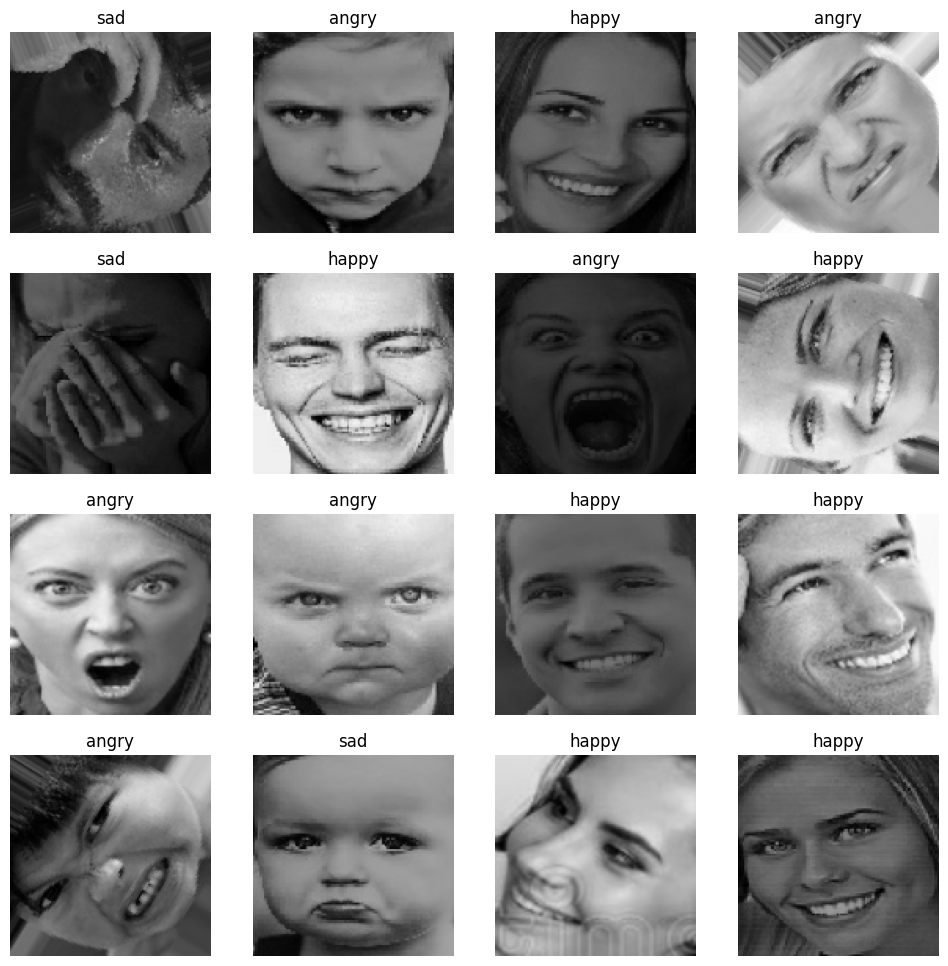

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

Model

In [ ]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])
def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [ ]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

In [ ]:
model=Sequential([
    #convolutional layer

    #layer1
    Conv2D(128,(3,3),activation='relu',input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),padding='valid'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    #layer2
    Conv2D(512,(3,3),activation='relu',padding='valid'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    #layer3
    Conv2D(512,(3,3),activation='relu',padding='valid'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.35),


    Flatten(),

    #classification
    Dense(2408,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1024,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),


    #output layer
    Dense(CONFIGURATION["NUM_CLASSES"],activation='softmax')
])
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2408)           │   241,650,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2408)           │         9,632 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,466,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,091,979 (942.58 MB)

 Trainable params: 247,082,811 (942.55 MB)

 Non-trainable params: 9,168 (35.81 KB)

Model Training

In [13]:
early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
lr_scheduler=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)
history=model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=25,
    verbose=1,
    callbacks=[early_stopping,lr_scheduler],
)

Epoch 1/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 106s 384ms/step - accuracy: 0.4679 - loss: 1.7102 - val_accuracy: 0.5610 - val_loss: 1.0011 - learning_rate: 1.0000e-04
Epoch 2/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 62s 292ms/step - accuracy: 0.5416 - loss: 1.3199 - val_accuracy: 0.5790 - val_loss: 1.1560 - learning_rate: 1.0000e-04
Epoch 3/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 66s 309ms/step - accuracy: 0.5698 - loss: 1.2129 - val_accuracy: 0.6414 - val_loss: 0.8572 - learning_rate: 1.0000e-04
Epoch 4/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 62s 290ms/step - accuracy: 0.5906 - loss: 1.1073 - val_accuracy: 0.5746 - val_loss: 0.9501 - learning_rate: 1.0000e-04
Epoch 5/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 84s 299ms/step - accuracy: 0.6245 - loss: 1.0463 - val_accuracy: 0.6791 - val_loss: 0.7746 - learning_rate: 1.0000e-04
Epoch 6/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 64s 302ms/step - accuracy: 0.6433 - loss: 0.9503 - val_accuracy: 0.5979 - val_loss: 0.9570 - learning_rate: 1.0000e-04
Epoch 7/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 63s 2

Evaluation

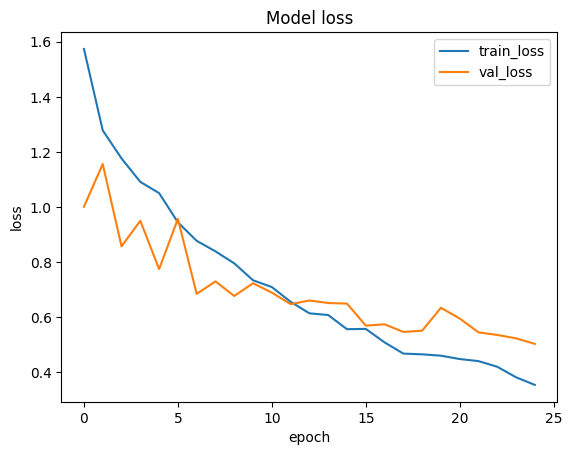

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

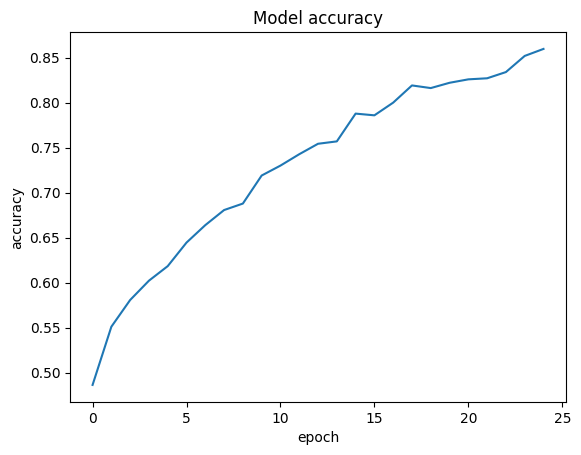

In [16]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step
              precision    recall  f1-score   support

       angry       0.76      0.77      0.77       515
       happy       0.86      0.90      0.88      1006
         sad       0.81      0.76      0.78       757

    accuracy                           0.82      2278
   macro avg       0.81      0.81      0.81      2278
weighted avg       0.82      0.82      0.82      2278



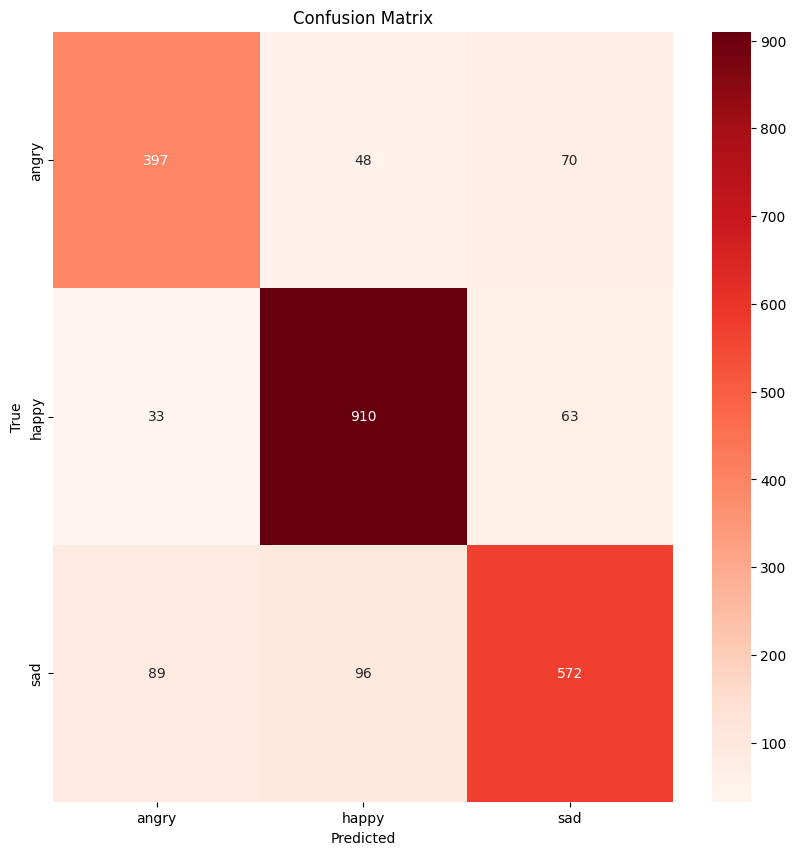

In [17]:
# Iterate over the validation dataset to get all images and labels
val_images = []
val_labels = []
for images, labels in validation_dataset:
    val_images.append(images)
    val_labels.append(labels)

# Concatenate the batches
val_images = tf.concat(val_images, axis=0)
val_labels = tf.concat(val_labels, axis=0)

predictions=model.predict(val_images)

y_true=np.argmax(val_labels,axis=1)
y_pred=np.argmax(predictions,axis=1)

# Use the class names from the CONFIGURATION dictionary
print(classification_report(y_true,y_pred,target_names=CONFIGURATION["CLASS_NAMES"]))

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt='d',cmap='Reds',xticklabels=CONFIGURATION["CLASS_NAMES"],yticklabels=CONFIGURATION["CLASS_NAMES"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Detection System

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


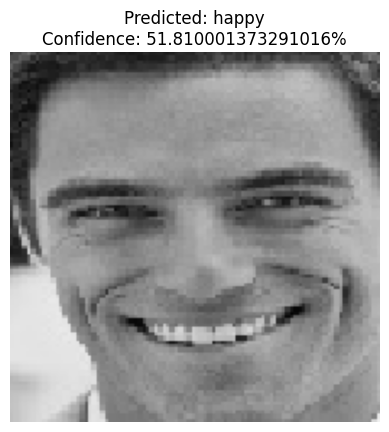

Emotion:happy,confidence:51.810001373291016%


In [20]:
from tensorflow.keras.preprocessing import image

def detect_emotion(image_path):
  img=image.load_img(image_path,target_size=(128,128),color_mode='rgb')
  img_array=image.img_to_array(img)/255.0
  img_array=np.expand_dims(img_array,axis=0)

  prediction=model.predict(img_array)
  predicted_index=np.argmax(prediction)
  predicted_class=CONFIGURATION["CLASS_NAMES"][predicted_index]
  confidence=round(prediction[0][predicted_index]*100,2)

  plt.imshow(img)
  plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence}%')
  plt.axis('off')
  plt.show()

  return predicted_class,confidence

predicted_emotion,confidence=detect_emotion("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/100711.jpg")
print(f"Emotion:{predicted_emotion},confidence:{confidence}%")

Save Modal

In [21]:
model.save('facial_emotion_detection_model.h5')